In [1]:
import numpy as np
import argparse
import os
import sys
import random
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
import mask_backward_v4
import matplotlib.pyplot as plt
# from mask_backward_v1 import mask_backward, mask_eval
# from mask_backward_v2 import mask_backward, mask_eval
from mask_backward_v4 import mask_backward, mask_eval
from utils import *
from mnet import MNet
sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#### import data to test mask_backward function

In [2]:
# data_gt = np.load('/home/huangz78/data/data_gt.npz')
# datafornn = np.load('/home/huangz78/data/datafornn.npz')
data = np.load('/home/huangz78/data/traindata_x.npz')
dtyp = torch.float
xfull = torch.tensor(data['xfull'],dtype=dtyp)
fullmask = torch.tensor(data['mask']) # a random mask

##### greedy mask and relevant data

In [3]:
from sklearn.model_selection import train_test_split

imgs   = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
masks  = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled
imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))

In [ ]:
# reload(utils)
# from utils import hfen
reload(mask_backward_v3)
from mask_backward_v3 import mask_backward, mask_eval
# import unet_model
# reload(unet_model)
# from unet_model import UNet

In [4]:
corefreq = 8
budget = 32
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
### load a unet for maskbackward
# UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
# unetpath = '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth'
# unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'

unet_skip = True
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
checkpoint = torch.load(unetpath)
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
UNET.train()
print('nn\'s are ready')

Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
nn's are ready


preselect_num =  8
budget =  32


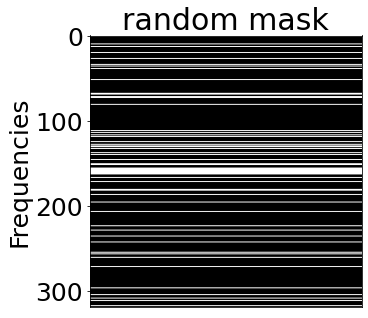

loss of the input mask:  (0.19981743395328522, 0.9298848509788513)
Iter 1, rows added: 126.0, rows reducted: 0.0, current samp. ratio: 0.56875
Iter 2, rows added: 0.0, rows reducted: 2.0, current samp. ratio: 0.5625
Iter 3, rows added: 2.0, rows reducted: 99.0, current samp. ratio: 0.259375
Iter 4, rows added: 20.0, rows reducted: 0.0, current samp. ratio: 0.321875
Iter 5, rows added: 12.0, rows reducted: 23.0, current samp. ratio: 0.2875
Iter 6, rows added: 41.0, rows reducted: 5.0, current samp. ratio: 0.4
Iter 7, rows added: 70.0, rows reducted: 32.0, current samp. ratio: 0.51875
Iter 8, rows added: 45.0, rows reducted: 77.0, current samp. ratio: 0.41875
Iter 9, rows added: 91.0, rows reducted: 36.0, current samp. ratio: 0.590625
Iter 10, rows added: 40.0, rows reducted: 76.0, current samp. ratio: 0.478125
Iter 11, rows added: 68.0, rows reducted: 45.0, current samp. ratio: 0.55
Iter 12, rows added: 65.0, rows reducted: 47.0, current samp. ratio: 0.60625
Iter 13, rows added: 50.0, r

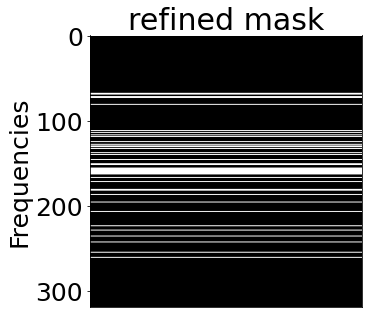

In [20]:
# for (8,32) setting
maxIter_mb = 30
lr_mb      = 1e-2
print('preselect_num = ',corefreq)
print('budget = ',budget)

xstar = xfull[0,:,:].view(-1,320,320)
# xstar    = imgs[testinds[testinds.size//2:],:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

# base_eq = torch.flatten( torch.tensor( [[1,0] for i in range(budget//2)] ) )
# highmask = torch.zeros((320-corefreq))
# highmask[(320-corefreq - budget)//2:(320-corefreq+budget)//2] = base_eq
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.view(-1,320-corefreq)

fullmask = mask_complete(highmask,320,dtyp=torch.float).view(-1)
kplot(fullmask,roll=False,img_name='random mask')

highmask_refined, _, mask_loss, init_mask_loss = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                  beta=1.,alpha=1e-4,c=1e-3,\
                  maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                  lr=lr_mb,mode='UNET',budget=budget,normalize=True,\
                  verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=False,\
                  save_cp=False)

fullmask = mask_complete(highmask_refined,320,dtyp=torch.float).view(-1)
kplot(fullmask,roll=False,img_name='refined mask')

In [ ]:
res_path = '/home/huangz78/checkpoints/mb_rec.npz'
res = np.load(res_path)
l2loss   = res['l2loss']
hfen     = res['hfen']
sparsity = res['sparsity']

In [ ]:
# for (24,56) setting
mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
              beta=1.,alpha=10**(-9.5),c=1e-2,\
              maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
              lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
              verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=True)

# 8-fold check

In [3]:
corefreq = 8
budget   = 32

mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
print('mnet is randomly initialized by PyTorch default setting~')

mnet is randomly initialized by PyTorch default setting~


In [4]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 9
# alpha_grid = 10**(np.array([-4,-3.5,-3,-2.5,-2]))
alpha_grid = 10**(np.linspace(-4.5,-3.5,NN))
# c_grid     = np.array([1e-4])
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1])
print('alpha grid: ',alpha_grid)
print('c grid: ',c_grid)
l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True # unet n_channels = 1
# unet_skip = False # unet n_channels = 2

alpha grid:  [3.16227766e-05 4.21696503e-05 5.62341325e-05 7.49894209e-05
 1.00000000e-04 1.33352143e-04 1.77827941e-04 2.37137371e-04
 3.16227766e-04]
c grid:  [0.0001 0.001  0.01   0.1   ]


In [5]:
lowfreqmask = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)[0]

yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho'),dim=(1,2)) # y is ROLLED!
y = torch.zeros((yfull.shape[0],2,yfull.shape[1],yfull.shape[2]),dtype=torch.float,device='cpu')
y[:,0,lowfreqmask==1,:] = torch.real(yfull)[:,lowfreqmask==1,:]
y[:,1,lowfreqmask==1,:] = torch.imag(yfull)[:,lowfreqmask==1,:]
highmask = torch.sigmoid( mnet(y) ).detach()

highmask = mask_makebinary(raw_normalize(highmask,budget,threshold=0.5),threshold=0.5,sigma=False)

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


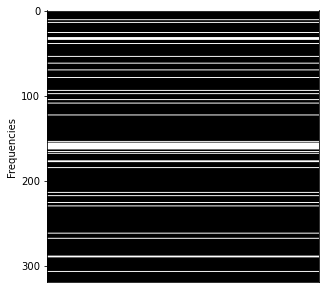

In [7]:
fullmask = mask_complete(highmask,320)
kplot(fullmask[0,:])

In [ ]:
# highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
# highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
#         UNET = UNet(n_channels=2,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
#         unetpath = '/home/huangz78/checkpoints/unet_2_'+str(unet_skip)+'.pt'
        UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
        unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        print('Unet loaded successfully from: ' + unetpath )
        UNET.train()
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

c_ind 1 out of 4
alpha_ind 1 out of 9
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16864521205425262, 0.8561416506767273)


/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Iter 1, rows added: 130.0, rows reducted: 0.0, current samp. ratio: 0.53125
Iter 2, rows added: 0.0, rows reducted: 6.4, current samp. ratio: 0.51125
Iter 3, rows added: 1.0, rows reducted: 85.2, current samp. ratio: 0.248125
Iter 4, rows added: 0.6, rows reducted: 1.4, current samp. ratio: 0.245625
Iter 5, rows added: 2.8, rows reducted: 6.0, current samp. ratio: 0.235625
Iter 6, rows added: 2.6, rows reducted: 0.0, current samp. ratio: 0.24375
Iter 7, rows added: 12.2, rows reducted: 2.4, current samp. ratio: 0.274375
Iter 8, rows added: 1.6, rows reducted: 1.2, current samp. ratio: 0.275625
Iter 9, rows added: 13.6, rows reducted: 7.4, current samp. ratio: 0.295
Iter 10, rows added: 4.4, rows reducted: 2.8, current samp. ratio: 0.3
Iter 11, rows added: 14.0, rows reducted: 23.8, current samp. ratio: 0.269375
Iter 12, rows added: 17.2, rows reducted: 4.2, current samp. ratio: 0.31
Iter 13, rows added: 16.2, rows reducted: 31.2, current samp. ratio: 0.263125
Iter 14, rows added: 20.2,

In [33]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [34]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

mode = sigpy
0.1780722737312317
0.10690502524375915


In [23]:
np.log10(alpha_grid[1])

-3.9

Text(0.5, 0, 'alpha')

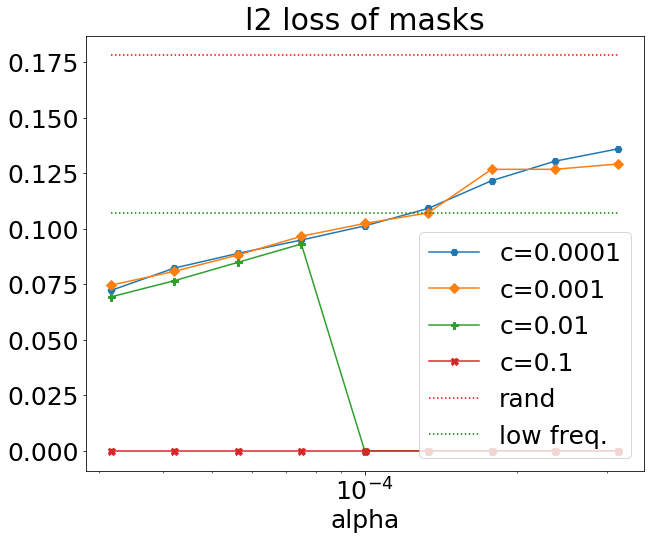

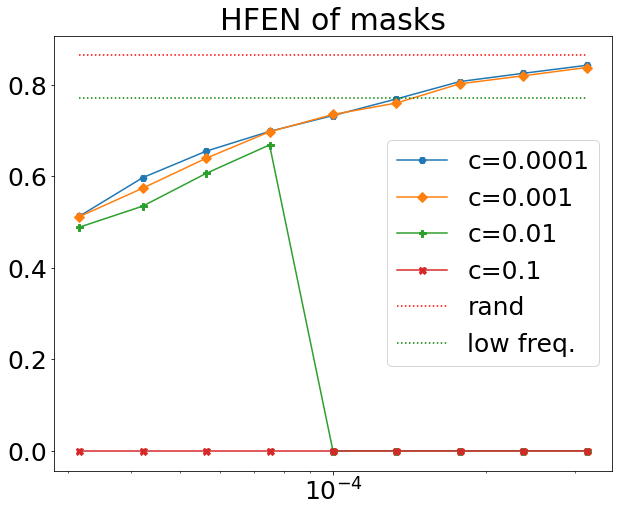

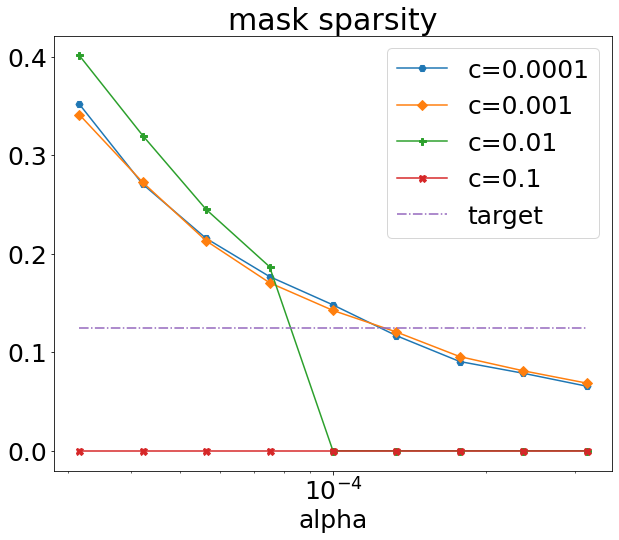

In [35]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand',linestyle = 'dotted')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.',linestyle = 'dotted')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand',linestyle = 'dotted')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.',linestyle = 'dotted')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

# 4-fold check

In [ ]:
corefreq = 16
budget   = 64
from mnet import MNet
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
mnet.apply(weights_init)
mnet.eval()
print('mnet is initialized')

In [ ]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 11
alpha_grid = 10**(np.linspace(-4.5,-3.5,NN))
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1])

l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True

In [ ]:
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
        UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
        unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        UNET.train()
    # highmask_refined,unet = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
    #                   beta=1.,alpha=alpha,c=c,\
    #                   maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
    #                   lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
    #                   verbose=True,dtyp=torch.float)
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

In [ ]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [ ]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

In [ ]:
# mnet_loss = mask_eval(full_highmask,xstar,mode='UNET',UNET=UNET)
# rand_loss = mask_eval(full_randmask,xstar,mode='UNET',UNET=UNET)
# lowf_loss = mask_eval(full_lowfmask,xstar,mode='UNET',UNET=UNET)
# print('mode = UNet')
# mnet_loss = mask_eval(full_highmask,xstar,mode='sigpy')
(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
(gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')
# print(mnet_loss)

print(rand_l2)
print(lowf_l2)
print(gred_l2)

In [ ]:
plt.figure()
plt.plot(alpha_grid,l2loss)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,label='greedy')
plt.title('l2 loss of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,hfen)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,sparsity,label='actual')
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')

In [ ]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.')
# plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,color='k',label='greedy')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.')
# plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,color='k',label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

In [ ]:
np.log10(alpha_grid[-5])

In [ ]:
from sigpy.mri.app import TotalVariationRecon
xstar = imgs[0,:,:]/torch.max(torch.abs(imgs[0,:,:].flatten()))
imgHeg, imgWid = xstar.shape[0], xstar.shape[1]
mps = np.ones((1,imgHeg,imgWid))
imgind = 15

NN = 15
Lambda_grid = 10**(np.linspace(-4,-2.5,NN))
errors = np.zeros((NN))

y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'),dim=(0,1))    
z = torch.zeros(y.shape).to(y.dtype)
z[masks[imgind,:]==1,:] = y[masks[imgind,:]==1,:]  
y_tmp = z.view(-1,imgHeg,imgWid).numpy()

xstar = xstar.numpy()

ind = 0
for Lambda in Lambda_grid:    
    x_tmp = np.fft.ifftshift( np.abs(TotalVariationRecon(y_tmp, mps, Lambda, show_pbar=False).run()) )  
    errors[ind] = np.linalg.norm(x_tmp - xstar,'fro')/np.linalg.norm(xstar,'fro')
    ind += 1
    
plt.figure()
plt.plot(Lambda_grid,errors)
plt.xscale('log')
plt.show()

### tune weight initialization function

In [ ]:
def mnet_weights_init(m):
    classname = m.__class__.__name__
    print(m)
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# reload(utils)
# from utils import mnet_weights_init

In [ ]:
corefreq = 8
budget = 32

mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(mnet_weights_init)
# mnet.eval()
mnet(torch.randn(1,2,320,320))

### old tests

In [ ]:
from mask_backward_v3 import ThresholdBinarizeMask

In [ ]:
binarize = ThresholdBinarizeMask.apply
x = torch.tensor([0.5,-0.5],requires_grad=True)

In [ ]:
y = binarize(torch.sigmoid(3*x))
ystar = torch.tensor([0.,1.])
print(y)

In [ ]:
loss = 1/2*torch.norm(y - ystar,p=2)
optimizer = optim.SGD([{'params': x}], lr=1e-2, momentum=0)
optimizer.zero_grad()
loss.backward()

In [ ]:
x.grad

In [ ]:
data_gt = np.load('/home/huangz78/data/data_gt.npz')
picind = np.random.randint(199)
xstar = data_gt['imgdata'][:,:,27]
xstar = xstar/np.max(np.abs(xstar))
# highmask = datafornn['labels'][picind,:]
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

In [ ]:
# reload(maskbackward)
# from maskbackward import mask_backward

#mode UNET:

reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

dtyp = torch.float
# unroll_block = 8; Lambda=6.1e-4; rho=1e1

# base = .05; expand = .15
# highmask = torch.zeros((round(320*(1-base))),dtype=torch.double)
# highmask[np.random.choice(round(320*(1-base)),round(320*expand),replace=False)] = 1

highmask = mask_filter(fullmask,base=round(320*0.05),roll=True)
print(highmask.shape)

In [ ]:
n_channels = 1
UNET =  UNet(n_channels=n_channels,n_classes=n_channels,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_' + str(n_channels) + '.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()

In [ ]:
## quick comparison between ifft recon and unet recon
imgHeg = 320; imgWid = 320
fullmask = torch.tensor( mask_complete(highmask,imgHeg,dtyp=torch.float) )
kplot(fullmask)
print('sparsity of fullmask = ',fullmask.sum().item()/imgHeg)

In [ ]:
xstar = torch.tensor(xstar,dtype=dtyp)
DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'))
z = torch.fft.ifftshift(torch.tensordot(torch.diag(fullmask).to(DTyp),y,dims=([1],[0])))
kplot(y,roll=False,log=True)
kplot(z,roll=True,log=True)

In [ ]:
imgHeg = 320; imgWid = 320
x_ifft = torch.abs(F.ifftn(z,dim=(0,1),norm='ortho')).to(dtyp)
x_unet = UNET(x_ifft.view(1,1,imgHeg,imgWid)).detach()

print('error of x_ifft = ', torch.norm(torch.flatten(x_ifft)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )
print('error of x_unet = ', torch.norm(torch.flatten(x_unet)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )

In [ ]:
from sigpy.mri.app import TotalVariationRecon
NN = 50
Lambda_grid = 10**np.linspace(-3.5,-3,NN)
errRec = np.zeros((NN))
ind = 1

mps  = np.ones((1,imgHeg,imgWid))
y_sp = np.reshape(z.numpy(),(-1,imgHeg,imgWid))
for Lambda in Lambda_grid:
# Lambda = 10**(-6.31) 
# Lambda = 10**(-3.2755) # np.log10(Lambda_grid[np.argmin(errRec)])
    print('{} out of {}'.format(ind,NN))
    x_sp = np.fft.fftshift( np.abs(TotalVariationRecon(y_sp, mps, Lambda,show_pbar=False).run()) ) 
    x_sp = torch.tensor(x_sp)
    errRec[ind-1] = torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro')
    ind += 1
#     print('error of x_sp = ', torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro'))

plt.figure()
plt.xscale('log')
plt.plot(Lambda_grid,errRec)

In [ ]:
np.linspace(-6,-4,gridnum)[8]

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

maxIter = 200
gridnum = 10
alpha_grid = 10**np.linspace(-4.6,-4.5,gridnum)
sr_rec = np.zeros((gridnum))
mloss_rec = np.zeros(gridnum)

ind = 0
for alpha in alpha_grid:
    print('[{}/{}]  alpha {}'.format(ind+1,gridnum,alpha))
    highmask_refined,refine_mloss,init_loss = mask_backward(highmask,xstar,\
                          beta=1., alpha=alpha,maxIter=maxIter,seed=0,break_limit=maxIter//2,\
                          lr=5e-4,mode='UNET',\
                          verbose=False,dtyp=dtyp)
    print('Difference between masks: \n',highmask_refined - highmask)
#     print('Refined mask is: \n',highmask_refined)
    mloss_rec[ind] = refine_mloss
    sr_rec[ind] = (torch.sum(highmask_refined).item() + 24)/320
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,mloss_rec,label='refined')
plt.scatter(alpha_grid,init_loss*np.ones(mloss_rec.shape),label='init.')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.scatter(alpha_grid,sr_rec,label='refined')
plt.scatter(alpha_grid,0.25*np.ones(mloss_rec.shape),label='init.')
plt.title('mask sampling ratio')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### mask binarize test

In [ ]:
from torch.autograd import Function
class ThresholdBinarizeMask(Function):
    def __init__(self):
        """
            Straight through estimator.
            The forward step binarizes the real-valued mask.
            The backward step estimate the non differentiable > operator using sigmoid with large slope (10).
        """
        super(ThresholdBinarizeMask, self).__init__()

    @staticmethod
    def forward(ctx, input):
        batch_size = len(input)
        results = [] 

        for i in range(batch_size):
            x = input[i:i+1]
            result = (x > .5).float()
            results.append(result)

        results = torch.cat(results, dim=0)
#         ctx.save_for_backward(input)
        return results  

    @staticmethod
    def backward(ctx, grad_output):
        slope = 1
#         input = ctx.saved_tensors

        # derivative of M
        current_grad = slope

        return current_grad * grad_output

In [ ]:
threshold = ThresholdBinarizeMask.apply

In [ ]:
x = torch.tensor([.1,.3,.7,.9,.6,.5,.21,.43])
x.requires_grad = True
b = threshold(x)

In [ ]:
y = torch.tensor([1., 1., 1., 1., 0., 1., 0., 1.])
loss = torch.norm((y-b),p=2)**2

In [ ]:
optimizer = optim.SGD([{'params': x}], lr=1e-2)

In [ ]:
optimizer.zero_grad()
loss.backward()
print('old x: ', x)
print('grad: ', x.grad)
optimizer.step()
print('updated x: ', x)

### arXiv

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward

# mode ADMM:

highmask = torch.zeros((round(320*0.9)))
highmask[np.random.choice(round(320*0.9),int(320*.1),replace=False)] = 1

naive_mloss = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
highmask_refined,refine_mloss = mask_backward(highmask,xstar,\
                          beta=1., alpha=1e1,maxIter=200,unroll_block=unroll_block,seed=0,break_limit=100,\
                          lr=5e-4,mode='ADMM',Lambda=Lambda,rho=rho,\
                          verbose=True,perturb=False,perturb_freq=5,eps=1e-2)

In [ ]:
# vary sampling ratio, observe RMSE for the same image.
reload(mask_backward_new)
from mask_backward_new import mask_backward

base=0.1
r_grid = np.array([0.1,0.15,0.2])
naive_mloss = np.zeros((r_grid.size))
refine_mloss = np.zeros((r_grid.size))

sampRatio = np.zeros((r_grid.size))

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/3)

np.random.seed(0)

ind = 0
for r in r_grid:
    print('\n r {}, the {} item out of {}'.format(r,ind+1,r_grid.size))
    highmask = torch.zeros((round(320*(1-base))))
    highmask[np.random.choice(round(320*(1-base)),int(320*r),replace=False)] = 1
    
    naive_mloss[ind] = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
    highmask_refined,refine_mloss[ind] = mask_backward(highmask,xstar,seed=0,\
                              beta=1., alpha=9.5e0,maxIter=maxIter,unroll_block=unroll_block,break_limit=break_limit,\
                              lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                              verbose=True,perturb=False,perturb_freq=5,eps=1e-2)
    sampRatio[ind] = (highmask_refined.sum().item() + round(320*0.1))/320
    ind += 1

In [ ]:
print('sampRatio: ',sampRatio)
plt.figure()
plt.scatter(r_grid,naive_mloss,label='naive')
plt.scatter(sampRatio,refine_mloss,label='refined')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

In [ ]:
## find a good alpha for l1 penalty
reload(mask_backward_new); reload(utils);
from mask_backward_new import mask_backward
alpha_grid = np.linspace(1,10,10)
sparsity_ = np.zeros(alpha_grid.size)
change_count = np.zeros(alpha_grid.size)

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/2)
# add samp. ratio. = .1 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?

base = 0.05
additional = 0.125

highmask = torch.zeros((round(320*(1-base))))
highmask[np.random.choice(round(320*(1-base)),round(320*additional),replace=False)] = 1

ind = 0
for alpha in alpha_grid:
    print('\n\talpha = {}'.format(alpha))
    highmask_refined,_ = mask_backward(highmask,xstar,\
                  beta=1, alpha=alpha,maxIter=maxIter,unroll_block=unroll_block,seed=0,break_limit=break_limit,\
                  lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                  perturb=False,perturb_freq=10,verbose=True)
    sparsity_[ind] = mask_complete(highmask_refined.to(torch.double),320).sum().item()/320
    change_count[ind] = torch.abs(highmask_refined - highmask).sum().item()
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,sparsity_,label='end')
plt.scatter(alpha_grid,(base+additional)*np.ones(alpha_grid.size),label='start')
plt.title('sparsity')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.figure()
plt.scatter(alpha_grid,change_count)
# plt.xscale('log')
plt.title('change count')

In [ ]:
naive_mloss = mask_eval(mask_complete(highmask,imgHeg,dtyp=dtyp),xstar,mode='UNET',UNET=UNET,dtyp=dtyp) * 100
print('naive mask loss = ',naive_mloss)

In [ ]:
### verify that UNET works fine
z = apply_mask(full_gredmask,yfull,mode='c')
xs = torch.abs(F.ifftn(F.ifftshift(z),dim=(1,2),norm='ortho'))
xs = torch.reshape(xs,(xs.shape[0],1,xs.shape[1],xs.shape[2]))

UNET.eval()
imgind = 0
xrecon = UNET(xs)
plt.figure()
plt.title('recon')
plt.imshow(xrecon.detach().numpy()[imgind,0,:,:])
plt.colorbar()
plt.show()

plt.figure()
plt.title('gt')
plt.imshow(xstar.detach().numpy()[imgind,:,:])
plt.colorbar()
plt.show()
print(torch.norm(xrecon[imgind,0,:,:]-xstar[imgind,:,:],'fro')/torch.norm(xstar[imgind,:,:],'fro').item())

In [ ]:
reload(utils)
from utils import hfen

In [ ]:
torch.squeeze(xrecon)[0,:,:].shape

In [ ]:
hfen(torch.squeeze(xrecon)[imgind,:,:],xstar[imgind,:,:],base=0)